In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [28]:
print(max(-4,0))

0


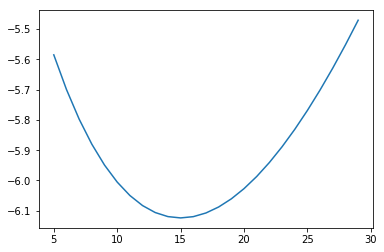

In [32]:
def calc_price(theta1, theta2, mu1, mu2, cost):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    return np.maximum(p1,0), np.maximum(p2,0)
  
    
def calc_t(theta1, theta2, mu1, mu2, cost):
    """compute the proportion of people choosing each insurer"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return np.clip(t_hat,0,1)


def calc_profits(theta1, theta2, mu1, mu2, cost):
    """compute profits for each firm"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t1 = calc_t(theta1, theta2, mu1, mu2, cost)
    return t1*np.maximum(p1-theta1*mu1,0)


def hosp_profits(theta1,theta2,mu1,mu2,cost):
    t1 = calc_t(theta1, theta2, mu1, mu2, cost)
    return t1*theta1*mu1 +  (1-t1)*theta2*mu2 


def outside_seq(theta1,mu1,cost,listprice):
    """compute outside option sequential case"""
    price = (listprice+ mu1*theta1)/2
    return np.clip((listprice - price)/cost ,0,1)*mu1*theta1

    
def outside_simlt(mu1,cost,listprice):
    """outside option in simult case"""
    return 3*listprice**2/(32*cost)

    
#arbitrary outside option...
def nash_in_nash(theta1, theta2, mu1, mu2, cost, outside):
    term1 = calc_profits(theta1, theta2, mu1, mu2, cost)
    term2 = max(hosp_profits(theta1,theta2,mu1,mu2,cost)-outside,0)
    obj = -1*(term1*term2)**.5
    return obj

plt.plot([i for i in range(5,30)],  [nash_in_nash(i, 15, .5, .5, 10, 0) for i in range(5,30)])

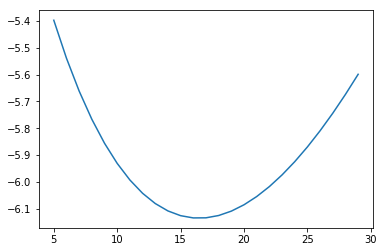

In [57]:
plt.plot([i for i in range(5,30)],  [nash_in_nash(i, 16.5, .5, .5, 10, 
                                                   outside_seq(16.5, .5, 10, 10)) for i in range(5,30)])

In [65]:
def bargain_helper(theta1, theta2, mu1, mu2, cost,listprice):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_seq(theta2,mu2,cost,listprice)
    result = minimize(nash_in_nash, theta1, args=(theta2, mu1, mu2, cost, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


print(bargain_helper(16.45, 16.45, .5, .5, 10, 10))

[16.45793182]


In [62]:
def bargain_helper(theta1, theta2, mu1, mu2, cost, listprice):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_simlt(mu2,cost,listprice)
    result = minimize(nash_in_nash, theta1, args=(theta2, mu1, mu2, cost, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


print(bargain_helper(16.8, 16.8, .5, .5, 10, 10))

[16.86003662]


In [61]:
def simult_bargain(theta1, theta2, mu1, mu2, cost, outside):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, mu1, mu2, cost, outside)
        theta2 = bargain_helper(theta2, theta1, mu2, mu1, cost, outside)
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2


print(simult_bargain(15,15,.5,.5,10,10))

(array([16.8749931]), array([16.87501779]))


In [67]:
print(calc_price(16.874,16.874, .5, .5, 10))
print(calc_t(16.874,16.874, .5, .5, 10))
print('------')
print(calc_price(16.845,16.845, .5, .5, 10))
print(calc_t(16.45,16.45, .5, .5, 10))

(18.436999999999998, 18.436999999999998)
0.5
------
(18.4225, 18.4225)
0.5


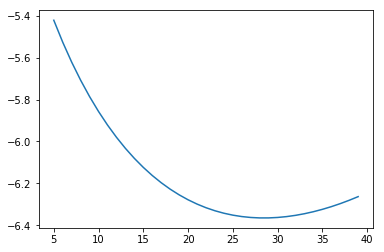

In [35]:
def seq_obj(theta1, mu1, mu2, cost, outside):
    """ theta2 in the second stage """
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, outside)
    return nash_in_nash(theta1, theta2, mu1, mu2, cost, outside)

plt.plot([i for i in range(5,40)],  [seq_obj(i, .5, .5, 10, 0) for i in range(5,40)])

In [19]:
def seq_bargain(theta1, mu1, mu2, cost, outside):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(mu1, mu2, cost, outside),
                      method='Nelder-Mead', options={'disp': False})
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, outside)
    return theta1, theta2


print(seq_bargain(18,.5,.5,10,0))

(array([28.4765625]), array([18.91447556]))


In [23]:
def make_table(arg, steps, params):
    min_arg, max_arg, no_step = steps
    
    cols = ['eq_type','distance_cost','mc1','mc2','profit1','profit2','hosp_profit','share1','share2']
    
    indep_var = np.linspace(min_arg, max_arg, no_step)
    results = []
    
    for var in indep_var:
        param_copy = list(params)
        param_copy[arg] = var
        mu1,mu2,cost,outside = param_copy
        for eq_type in ['Simultaneous', 'Sequential']:
            
            mc1,mc2 = 10, 10
            
            if eq_type == 'Simultaneous':
                mc1,mc2 = simult_bargain(mc1,mc2, mu1, mu2, cost, outside)
            else:
                mc1,mc2 = seq_bargain(mc1, mu1, mu2, cost, outside)
            mc1, mc2 = mc1[0],mc2[0]
            profit1 = calc_profits(mc1, mc2, mu1, mu2, cost)
            profit2 = calc_profits(mc2, mc1, mu2, mu1, cost)
            hosp_prof = hosp_profits(mc1, mc2, mu1, mu2, cost)
            share1 = calc_t(mc1, mc2, mu1, mu2, cost)
            share2 = 1-share1
            results.append([eq_type,cost,mc1,mc2,profit1,profit2,hosp_prof, share1,share2])
            
        
    return pd.DataFrame(data=results, columns=cols)
    

make_table(2,(10,20,2), (.5,.5,10,0))

,eq_type,distance_cost,mc1,mc2,profit1,profit2,hosp_profit,share1,share2
0,Simultaneous,10.0,15.000032,14.999973,4.999990,5.000010,7.500001,0.500000,0.500000
1,Sequential,10.0,28.476562,18.914476,3.533310,6.720672,11.466787,0.420316,0.579684
2,Simultaneous,20.0,30.000004,30.000010,10.000001,9.999999,15.000003,0.500000,0.500000
3,Sequential,20.0,57.007812,37.848748,7.061732,13.448087,22.949411,0.420171,0.579829
